<a href="https://colab.research.google.com/github/Thiago1alberto/Reconhecimento-de-emo-es-faciais-/blob/main/Face%20Emotion%20recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Imports padrão
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [13]:
# Imports do TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical

In [14]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# CAMINHOS RELATIVOS das pastas
data_path = "/content/drive/MyDrive/TCC/FER_2013"
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

# Mapear emoções para rótulos numéricos e vice-versa
emotion_to_label = {'fear': 0, 'angry': 1, 'disgust': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
label_to_emotion = {v: k for k, v in emotion_to_label.items()}

# Carregar o DataFrame df_pixels
dataframe_pixels_path = os.path.join(data_path, 'dataframe_pixels.json')
df_pixels = pd.read_json(dataframe_pixels_path, lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df_pixels.head()

,label,pixels,conjunto
0,0,"[[254, 177, 109, 102, 83, 80, 101, 134, 157, 1...",treino
1,0,"[[46, 55, 50, 38, 25, 30, 44, 56, 69, 103, 129...",treino
2,0,"[[171, 133, 89, 63, 99, 100, 91, 105, 99, 95, ...",treino
3,0,"[[88, 88, 88, 89, 89, 89, 87, 84, 81, 69, 41, ...",treino
4,0,"[[136, 121, 93, 115, 119, 122, 139, 131, 78, 1...",treino


In [16]:
# Contagem de imagens em cada conjunto (treino e teste)
label_to_emotion_pt = {
    0: 'medo',
    1: 'raiva',
    2: 'desgosto',
    3: 'felicidade',
    4: 'neutro',
    5: 'tristeza',
    6: 'surpresa'
}
train_count = df_pixels[df_pixels['conjunto'] == 'treino'].shape[0]
test_count = df_pixels[df_pixels['conjunto'] == 'teste'].shape[0]

print(f"Total de imagens no conjunto de treino: {train_count}")
print(f"Total de imagens no conjunto de teste: {test_count}")

# Contagem de imagens em cada subconjunto de emoções para cada conjunto
train_emotions_count = df_pixels[df_pixels['conjunto'] == 'treino']['label'].value_counts().sort_index()
test_emotions_count = df_pixels[df_pixels['conjunto'] == 'teste']['label'].value_counts().sort_index()

# Mapear os índices para os nomes das emoções
train_emotions_count.index = train_emotions_count.index.map(label_to_emotion_pt)
test_emotions_count.index = test_emotions_count.index.map(label_to_emotion_pt)

print("\nContagem de emoções no conjunto de treino:")
print(train_emotions_count)
print("\nContagem de emoções no conjunto de teste:")
print(test_emotions_count)

Total de imagens no conjunto de treino: 28727
Total de imagens no conjunto de teste: 7181

Contagem de emoções no conjunto de treino:
label
medo          4097
raiva         4000
desgosto       436
felicidade    7215
neutro        4973
tristeza      4830
surpresa      3176
Name: count, dtype: int64

Contagem de emoções no conjunto de teste:
label
medo          1024
raiva          958
desgosto       111
felicidade    1774
neutro        1233
tristeza      1247
surpresa       834
Name: count, dtype: int64


In [17]:
# Criar DataFrame para plotagem
plot_data = pd.DataFrame({
    'Emoção': train_emotions_count.index,
    'Treino': train_emotions_count.values,
    'Teste': test_emotions_count.values
})

# Transformar o DataFrame para o formato longo (long format)
plot_data = plot_data.melt(id_vars='Emoção', var_name='Conjunto', value_name='Contagem')

print("\nDados para plotagem:")
print(plot_data)


Dados para plotagem:
        Emoção Conjunto  Contagem
0         medo   Treino      4097
1        raiva   Treino      4000
2     desgosto   Treino       436
3   felicidade   Treino      7215
4       neutro   Treino      4973
5     tristeza   Treino      4830
6     surpresa   Treino      3176
7         medo    Teste      1024
8        raiva    Teste       958
9     desgosto    Teste       111
10  felicidade    Teste      1774
11      neutro    Teste      1233
12    tristeza    Teste      1247
13    surpresa    Teste       834


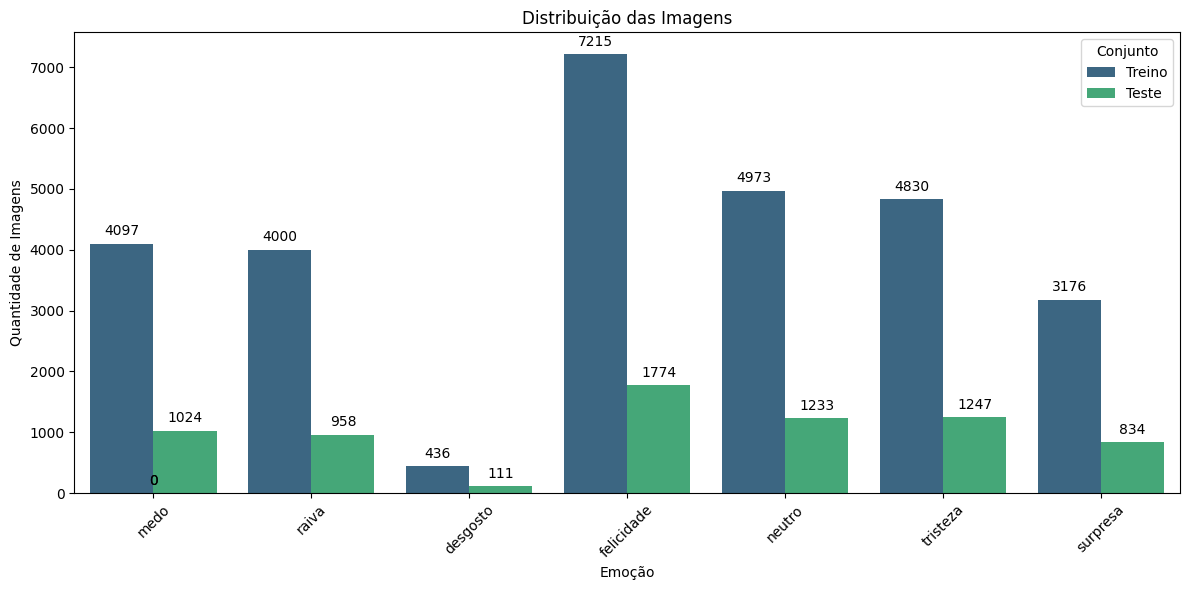

In [18]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Emoção', y='Contagem', hue='Conjunto', data=plot_data, palette='viridis')
plt.title('Distribuição das Imagens')
plt.xlabel('Emoção')
plt.ylabel('Quantidade de Imagens')
plt.xticks(rotation=45)
plt.legend(title='Conjunto')

# Adicionar valores nas barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

output_path = '/content/drive/MyDrive/TCC/FER_2013/distribuicao_imagens_por_emocao_e_conjunto.png'
plt.tight_layout()
plt.savefig(output_path)
plt.show()

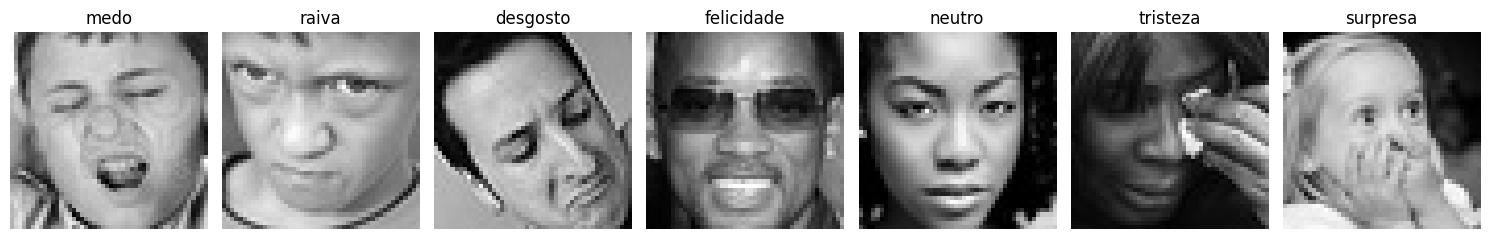

In [19]:
label_to_emotion_pt = {
    0: 'medo',
    1: 'raiva',
    2: 'desgosto',
    3: 'felicidade',
    4: 'neutro',
    5: 'tristeza',
    6: 'surpresa'
}

# Imports necessários
import matplotlib.pyplot as plt
import numpy as np

# Selecionar uma imagem de cada emoção
sample_images = []
for emotion in range(7):
    sample = df_pixels[df_pixels['label'] == emotion].iloc[0]
    sample_images.append((sample['pixels'], label_to_emotion_pt[emotion]))

# Plotar as imagens
plt.figure(figsize=(15, 10))

for i, (pixels, emotion) in enumerate(sample_images):
    plt.subplot(1, 7, i + 1)
    plt.imshow(np.array(pixels), cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, ReLU, Add
from tensorflow.keras.regularizers import l2

# Função para criar um Inverted Residual Block
def InvertedResidualBlock(x, expansion, channels):
    # Expansão
    y = Conv2D(expansion * x.shape[-1], 1, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    y = BatchNormalization()(y)
    y = ReLU(6.)(y)

    # Depthwise convolution
    y = DepthwiseConv2D(3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(y)
    y = BatchNormalization()(y)
    y = ReLU(6.)(y)

    # Projection
    y = Conv2D(channels, 1, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(y)
    y = BatchNormalization()(y)

    # Residual connection
    if y.shape[-1] == x.shape[-1]:
        y = Add()([x, y])

    return y

# Definindo a arquitetura do modelo
def create_model():
    input_img = Input(shape=(48, 48, 1))

    x = Conv2D(32, 3, strides=2, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(input_img)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = SeparableConv2D(32, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 64)
    x = SeparableConv2D(64, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SeparableConv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 256)
    x = SeparableConv2D(256, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SeparableConv2D(256, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 512)
    x = SeparableConv2D(512, 3, padding='same', use_bias=False, kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = InvertedResidualBlock(x, 6, 512)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    return model

# Separando features e labels
X = np.stack(df_pixels['pixels'].values)
y = df_pixels['label'].values

# One-hot encoding dos labels
y = to_categorical(y)

# Dividindo em conjuntos de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Normalizando os dados de pixel
#X_train = X_train.astype('float32') / 255.0
#X_test = X_test.astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
)

# Criando e compilando o modelo
model = create_model()

# Adam com aprendizado dinâmico e decaimento
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule, amsgrad=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Treinamento do modelo com data augmentation
model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=80,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)

# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/80
1796/1796 [==============================] - 98s 43ms/step - loss: 2.2458 - accuracy: 0.2862 - val_loss: 2.2187 - val_accuracy: 0.2700
Epoch 2/80
1796/1796 [==============================] - 68s 38ms/step - loss: 1.8477 - accuracy: 0.4089 - val_loss: 1.6580 - val_accuracy: 0.4744
Epoch 3/80
1796/1796 [==============================] - 69s 39ms/step - loss: 1.6436 - accuracy: 0.4655 - val_loss: 1.5451 - val_accuracy: 0.4767
Epoch 4/80
1796/1796 [==============================] - 69s 38ms/step - loss: 1.5304 - accuracy: 0.4960 - val_loss: 1.5303 - val_accuracy: 0.4919
Epoch 5/80
1796/1796 [==============================] - 70s 39ms/step - loss: 1.4568 - accuracy: 0.5164 - val_loss: 1.3884 - val_accuracy: 0.5379
Epoch 6/80
1796/1796 [==============================] - 70s 39ms/step - loss: 1.4034 - accuracy: 0.5321 - val_loss: 1.3206 - val_accuracy: 0.5606
Epoch 7/80
1796/1796 [==============================] - 69s 38ms/step - loss: 1.3611 - accuracy: 0.5476 - val_loss: 1.2744 -

In [ ]:
"""def create_augmentation_generator():
    return ImageDataGenerator(
        rotation_range=np.random.randint(0, 30),  # Aleatório entre 0 e 30 graus
        width_shift_range=np.random.uniform(0.0, 0.2),  # Aleatório entre 0 e 0.2
        height_shift_range=np.random.uniform(0.0, 0.2),  # Aleatório entre 0 e 0.2
        horizontal_flip=np.random.choice([True, False]),  # Aleatório entre True e False
        zoom_range=np.random.uniform(0.0, 0.2),  # Aleatório entre 0 e 0.2
        shear_range=np.random.uniform(0.0, 0.2),  # Aleatório entre 0 e 0.2
        brightness_range=[0.8, 1.2],  # Manter fixo para consistência
        fill_mode='nearest',
    )"""

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtem as previsões do modelo no conjunto de teste
y_pred = create_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Avaliação do modelo com métricas
print(classification_report(y_true, y_pred_classes, target_names=label_to_emotion.values()))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_emotion.values(), yticklabels=label_to_emotion.values())
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

# Calcula a matriz de confusão em percentagem
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plota a matriz de confusão em percentagem
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_to_emotion.values(), yticklabels=label_to_emotion.values())
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão (em %)')
plt.show()

In [ ]:
# Calcula a matriz de confusão em percentagem
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plota a matriz de confusão em percentagem
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_to_emotion.values(), yticklabels=label_to_emotion.values())
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão (em %)')
plt.show()